**unfinished problem:**
- Which masking is used for the datasets? (investigate visualize_sources_as_masks function and visualize_sources_as_waveform function)
- Why using different panning degree for ICA preprocessing?

# Data Prep and Visuals

In [58]:
!pip install sox

In [59]:
%matplotlib inline

import nussl
import matplotlib.pyplot as plt
import time
import warnings
import numpy as np

warnings.filterwarnings("ignore")

In [60]:
import scaper
import os
import zipfile
import subprocess

### Separation via Time-Frequency Masking

Masking is one of the most effective ways to separate sounds from a mixture. Masking means to assign each of the time-frequency (shown by the spectrogram graph) bins to one of the n sources in part or in whole. (https://nussl.github.io/docs/tutorials/masking_audio_signals.html)
- SoftMask:
    - Construct **soft mask** for the Short-time Fourier transformed (STFT) data, apply the soft mask to the mixture to separate a source via element-wise multiplying the STFT and adding the mixture phase, then can get the separated source.
- BinaryMask:
    - Basically the same, except that **masks are binary** instead of soft.

In [61]:
def visualize_and_embed(sources):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    # visualize the masks
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='mel', db_cutoff=-60, alpha_amount=2.0)
    plt.subplot(212)
    nussl.utils.visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    # listen to the original sources that make up the mixture
    nussl.play_utils.multitrack(sources)

## Data
### already conducted STFT and are masked, the visuals uses different colors to visualize the masks
### stft_params (default): 32ms window length, 8ms hop, ‘hann’ window
### (settings are in nussl.datasets.BaseDataset)

**Data 1**

MUSDB18 Dataset: 7s snippets of 144 tracks from 4 sources, have both mixed and seperated files

```
{
    'mix': [AudioSignal object containing mix audio],
    'source': {
        'bass': [AudioSignal object containing vocals],
        'drums': [AudioSignal object containing drums],
        'other': [AudioSignal object containing other],
        'vocals': [AudioSignal object containing vocals],
    }
    'metadata': {
        'labels': ['bass', 'drums', 'other', 'vocals']
    }
}
```

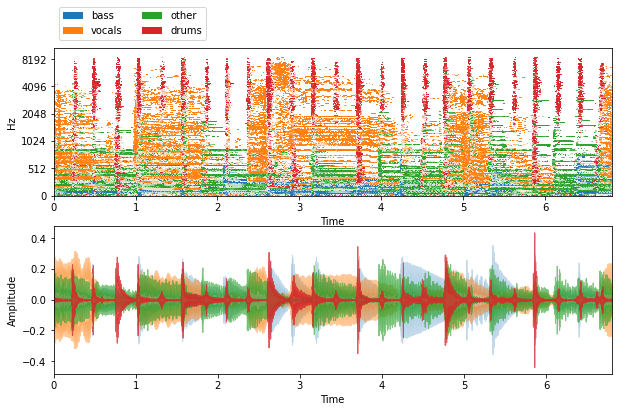


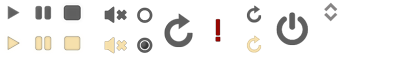
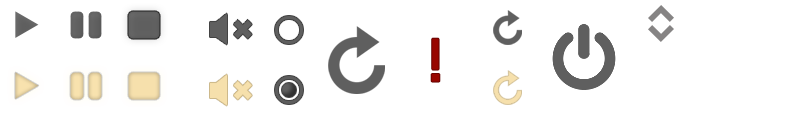
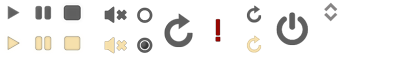

In [62]:
# data1
musdb = nussl.datasets.MUSDB18(download=True)

i = 40 #or get a random track like this: np.random.randint(len(musdb))

item = musdb[i]
mix = item['mix']
sources = item['sources']

visualize_and_embed(sources)

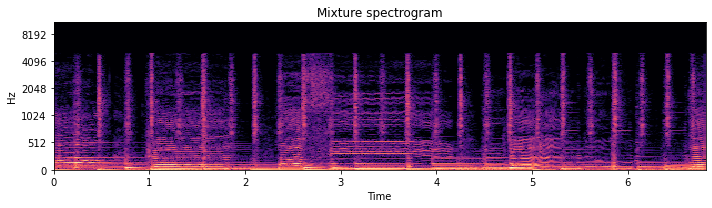

In [20]:
plt.figure(figsize=(10, 3))
plt.title('Mixture spectrogram')
nussl.utils.visualize_spectrogram(mix, y_axis='mel')
plt.tight_layout()
plt.show()

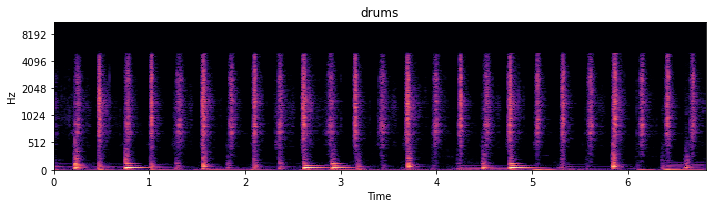

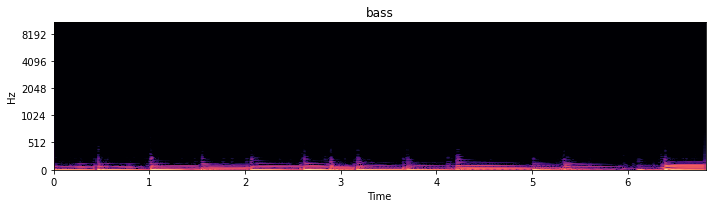

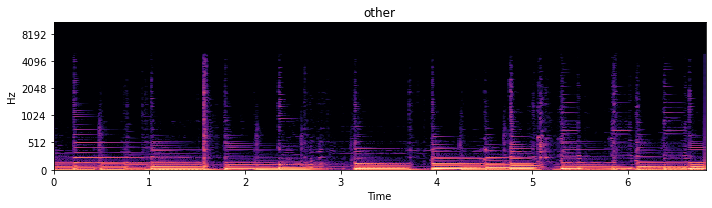

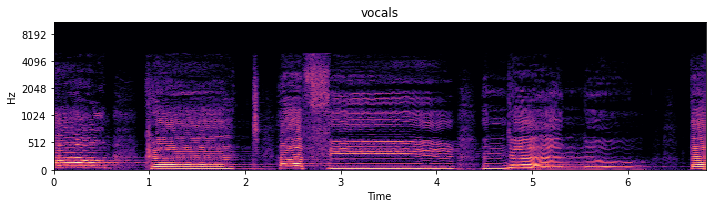

In [30]:
for i in sources.keys():
    plt.figure(figsize=(10, 3))
    plt.title(i)
    nussl.utils.visualize_spectrogram(sources[i], y_axis='mel')
    plt.tight_layout()
    plt.show()

In [9]:
item

{'mix': <nussl.core.audio_signal.AudioSignal at 0x7f2ef1f07a50>,
 'sources': {'drums': <nussl.core.audio_signal.AudioSignal at 0x7f2e9721de50>,
  'bass': <nussl.core.audio_signal.AudioSignal at 0x7f2e971b9c50>,
  'other': <nussl.core.audio_signal.AudioSignal at 0x7f2e971c8e90>,
  'vocals': <nussl.core.audio_signal.AudioSignal at 0x7f2e97f03d50>},
 'metadata': {'labels': ['bass', 'drums', 'other', 'vocals']}}

**Data 2**

Data from Scaper - https://scaper.readthedocs.io/en/latest/index.html

- Scaper is a tool for creating complex soundscapes containing multiple isolated sources.
- Download some raw data from the Scaper github and then make some soundscapes with Scaper.
- Output: 10s snippets of 5 tracks (each track has slightly different type of sources) from 4 sources, have both mixed and seperated files

```
/home/pseetharaman/.nussl/tutorial/scaper/generated
├── 0.jams
├── 0.wav
├── 0_events
│   ├── background0_park.wav
│   ├── foreground0_siren.wav
│   ├── foreground1_siren.wav
│   └── foreground2_human_voice.wav
├── 1.jams
├── 1.wav
├── 1_events
│   ├── background0_park.wav
│   ├── foreground0_siren.wav
│   ├── foreground1_car_horn.wav
│   └── foreground2_siren.wav
├── 2.jams
├── 2.wav
├── 2_events
│   ├── background0_park.wav
│   ├── foreground0_siren.wav
│   ├── foreground1_siren.wav
│   └── foreground2_siren.wav
├── 3.jams
├── 3.wav
├── 3_events
│   ├── background0_park.wav
│   ├── foreground0_siren.wav
│   ├── foreground1_siren.wav
│   └── foreground2_human_voice.wav
├── 4.jams
├── 4.wav
└── 4_events
    ├── background0_park.wav
    ├── foreground0_car_horn.wav
    ├── foreground1_siren.wav
    └── foreground2_human_voice.wav
```

In [10]:
# Download the audio automatically
url = "https://github.com/justinsalamon/scaper/archive/v1.2.0.zip"
download_path = os.path.expanduser('~/.nussl/tutorial/scaper')

if not os.path.exists(download_path):
    subprocess.run(f'wget {url}', shell=True)
    subprocess.run(f'unzip v1.2.0.zip', shell=True)
    os.makedirs(download_path, exist_ok=True)
    subprocess.run(f'cp -r scaper-1.2.0/tests/data/audio {download_path}', shell=True)
    subprocess.run(f'rm -rf scaper-1.2.0/', shell=True)
    subprocess.run(f'rm -rf v1.2.0.zip', shell=True)

In [11]:
path_to_audio = os.path.join(download_path, 'audio')
output_folder = os.path.join(download_path, 'generated')

os.makedirs(output_folder, exist_ok=True)

soundscape_duration = 10.0
seed = 123
num_mixtures = 5

foreground_folder = os.path.join(path_to_audio, 'foreground')
background_folder = os.path.join(path_to_audio, 'background')
sc = scaper.Scaper(soundscape_duration,
                   foreground_folder,
                   background_folder,
                   random_state=seed)
sc.ref_db = -20

sc.add_background(label=('const', 'park'),
                  source_file=('choose', []),
                  source_time=('const', 0))

sc.add_event(label=('const', 'siren'),
              source_file=('choose', []),
              source_time=('const', 0),
              event_time=('uniform', 0, 9),
              event_duration=('truncnorm', 3, 1, 0.5, 5),
              snr=('normal', 10, 3),
              pitch_shift=('uniform', -2, 2),
              time_stretch=('uniform', 0.8, 1.2))

for _ in range(2):
    sc.add_event(label=('choose', []),
                 source_file=('choose', []),
                 source_time=('const', 0),
                 event_time=('uniform', 0, 9),
                 event_duration=('truncnorm', 3, 1, 0.5, 5),
                 snr=('normal', 10, 3),
                 pitch_shift=None,
                 time_stretch=None)

for i in range(num_mixtures):
    audiofile = os.path.join(output_folder, f'{i}.wav')
    jamsfile = os.path.join(output_folder, f'{i}.jams')
    sc.generate(audiofile, jamsfile,
                allow_repeated_label=True,
                allow_repeated_source=True,
                reverb=None,
                disable_sox_warnings=True,
                no_audio=False,
                save_isolated_events=True) # this is important!

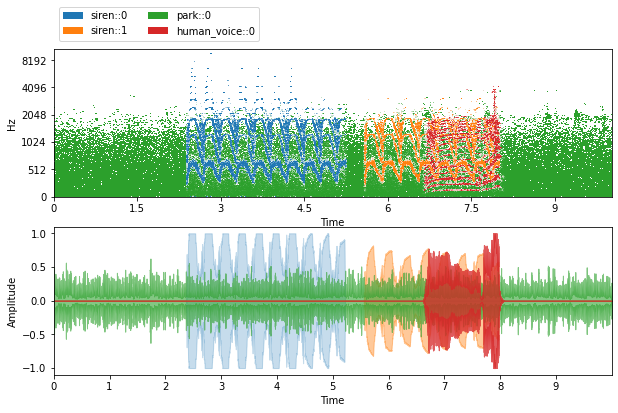


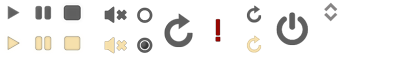
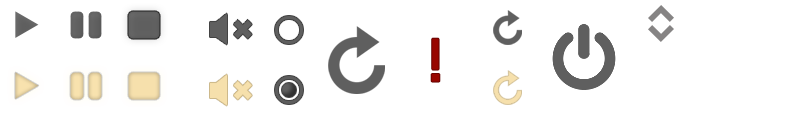
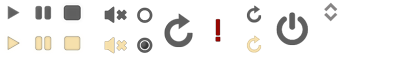

In [18]:
sca = nussl.datasets.Scaper(output_folder)

i = 0 # pick a track

item_ = sca[i]
mix_ = item_['mix']
sources_ = item_['sources']

visualize_and_embed(sources_)

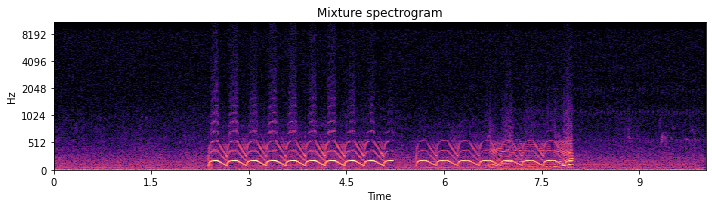

In [21]:
plt.figure(figsize=(10, 3))
plt.title('Mixture spectrogram')
nussl.utils.visualize_spectrogram(mix_, y_axis='mel')
plt.tight_layout()
plt.show()

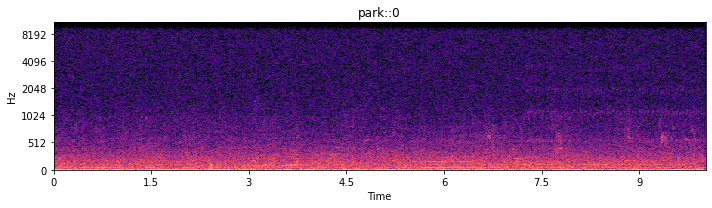

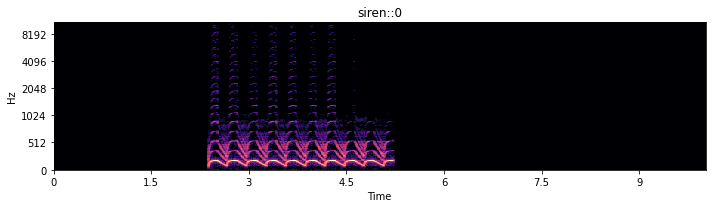

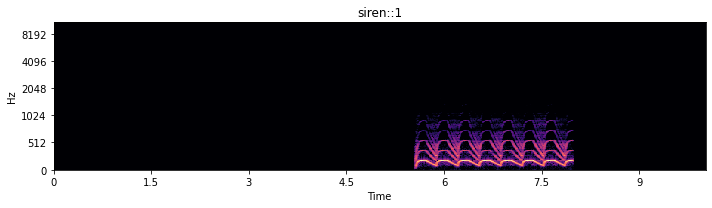

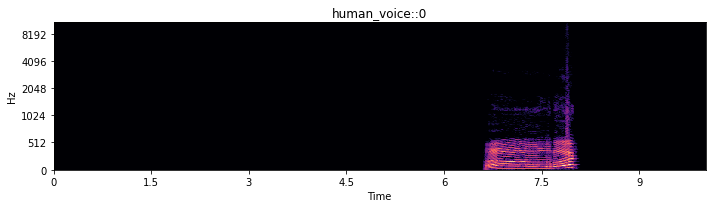

In [31]:
for i in sources_.keys():
    plt.figure(figsize=(10, 3))
    plt.title(i)
    nussl.utils.visualize_spectrogram(sources_[i], y_axis='mel')
    plt.tight_layout()
    plt.show()

In [19]:
item_

{'mix': <nussl.core.audio_signal.AudioSignal at 0x7f2e965a61d0>,
 'sources': {'park::0': <nussl.core.audio_signal.AudioSignal at 0x7f2e9490bc50>,
  'siren::0': <nussl.core.audio_signal.AudioSignal at 0x7f2e965b7350>,
  'siren::1': <nussl.core.audio_signal.AudioSignal at 0x7f2e9490bed0>,
  'human_voice::0': <nussl.core.audio_signal.AudioSignal at 0x7f2e9490be10>},
 'metadata': {'scaper': <JAMS(file_metadata=<FileMetadata(...)>,
        annotations=[1 annotation],
        sandbox=<Sandbox(...)>)>,
  'labels': ['car_horn', 'human_voice', 'siren']}}

# ICA
### Nussl’s ICA is a wrapper for sci-kit learn’s implementation of FastICA, and provides a way to interop between nussl’s AudioSignal objects and FastICA.

In [76]:
sources_a = [value for key, value in sources.items()]
# Use negative numbers to pan left by degree 35
a = nussl.mixing.pan_audio_signal(sources_a[2], -35)
# randomly delay by 1-19 samples for each channel
a_delays = [np.random.randint(1, 20) for _ in range(a.num_channels)]
# The end of the audio signal is truncated for that channel so that the length remains the same as the original.
a = nussl.mixing.delay_audio_signal(a, a_delays)

# positive to pan right by degree 35
b = nussl.mixing.pan_audio_signal(sources_a[3], 35)
# randomly delay by 1-19 samples for each channel
b_delays = [np.random.randint(1, 20) for _ in range(b.num_channels)]
# The end of the audio signal is truncated for that channel so that the length remains the same as the original.
b = nussl.mixing.delay_audio_signal(b, b_delays)

# AudioSignal object containing mix audio
mix_new = a + b

# Extract new AudioSignal object from each channel
# get two channels of the mixed audio
audio_signals = [
    mix_new.make_audio_signal_from_channel(ch)
    for ch in range(mix_new.num_channels)
]

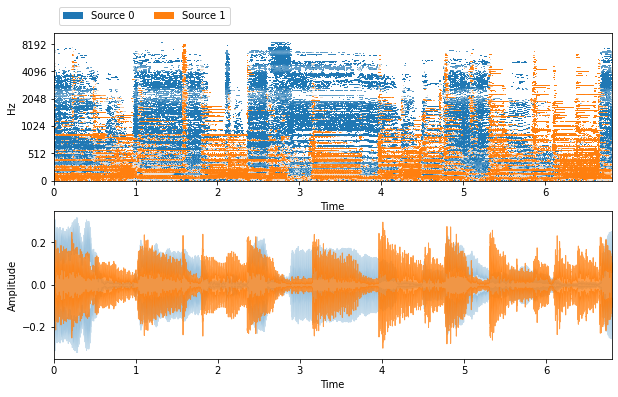


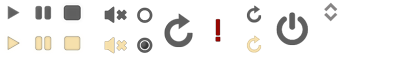
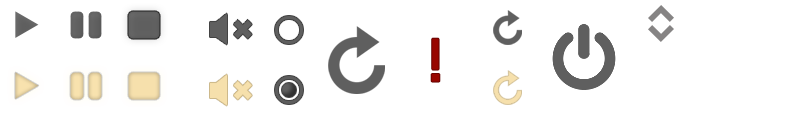
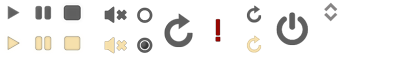

In [77]:
separator = nussl.separation.factorization.ICA(audio_signals)
estimates = separator()

estimates = {
    f'Source {i}': e for i, e in enumerate(estimates)
}

visualize_and_embed(estimates)

# Model Evaluation
https://nussl.github.io/docs/tutorials/evaluation.html